# SPIE 2020 - Denoising DBT projections using DnCNN with Residual Learning

## Importing libraries

In [73]:
from typing import List, Dict, Tuple
from copy import deepcopy
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras import Sequential, layers, activations
from keras.models import Model, load_model

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

from utils import *

## Loading dataset

Projections dimension: 650 x 1650

In [85]:
full_x_train, full_y_train, full_x_test, full_y_test = carrega_dataset(divisao=(80,20), embaralhar=True)

## Merging projections in one dimension

In [87]:
x_train =  np.reshape(full_x_train, (-1, 50, 50))
x_test = np.reshape(full_x_test, (-1, 50, 50))
y_train = np.reshape(full_y_train, (-1, 50, 50))
y_test = np.reshape(full_y_test, (-1, 50, 50)) 

In [88]:
del full_x_train
del full_y_train
del full_x_test
del full_y_test

In [89]:
x_train = x_train[:15000]
y_train = y_train[:15000]

x_test = x_test[:3750]
y_test = y_test[:3750]

In [90]:
x_test.shape

(3750, 50, 50)

In [91]:
np.random.seed(13)
np.random.shuffle(x_train)

np.random.seed(13)
np.random.shuffle(y_train)


np.random.seed(43)
np.random.shuffle(x_test)


np.random.seed(43)
np.random.shuffle(y_test)

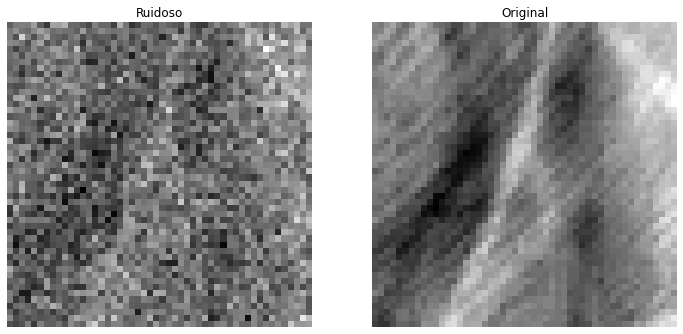

In [92]:
mostrar_lado_a_lado(imagens=[x_train[1500, :,:], y_train[1500,:,:]], titulos=['Ruidoso', 'Original'])

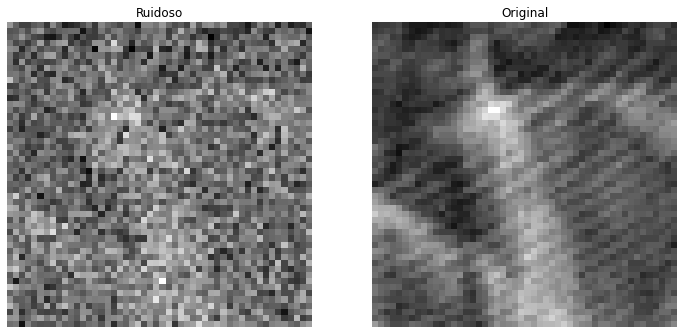

In [93]:
mostrar_lado_a_lado(imagens=[x_test[3010, :,:], y_test[3010,:,:]], titulos=['Ruidoso', 'Original'])

## Normalizing datasets between [0;1]

In [94]:
x_train = cv2.normalize(x_train, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
y_train = cv2.normalize(y_train, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)


x_test = cv2.normalize(x_test, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
y_test = cv2.normalize(y_test, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

## Adding color dimension

In [95]:
x_train = adiciona_a_dimensao_das_cores(x_train)
y_train = adiciona_a_dimensao_das_cores(y_train)

x_test = adiciona_a_dimensao_das_cores(x_test)
y_test = adiciona_a_dimensao_das_cores(y_test)

In [96]:
x_train.shape

(15000, 50, 50, 1)

In [97]:
x_test.shape

(3750, 50, 50, 1)

# Building model

## Hyper-parameters

In [98]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 10
NUMBER_OF_LAYERS = 10

In [99]:
model = keras.Sequential()
input = layers.Input(shape=(None, None, 1), name='input')

output = layers.Conv2D(filters=64,kernel_size=(3,3), strides=(1,1), 
                       padding='same', name='conv1')(input)
output = layers.Activation('relu')(output)

print(output.shape)

for layer in range(2, NUMBER_OF_LAYERS): # original é 19 em vez de 5
    output = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), 
                       padding='same', name='conv%d' %layer)(output)
    output = layers.BatchNormalization(axis=-1, epsilon=1e-3, name='batch_normalization%d' %layer)(output)
    output = layers.Activation('relu')(output)

output = layers.Conv2D(filters=1, kernel_size=(3,3), padding='same', strides=(1,1), name=f'conv{NUMBER_OF_LAYERS}')(output)

output = layers.Subtract(name='subtract')([input, output])

model = Model(inputs=input, outputs=output)

model.summary()

(None, None, None, 64)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 640         input[0][0]                      
__________________________________________________________________________________________________
activation_10 (Activation)      (None, None, None, 6 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, None, None, 6 36928       activation_10[0][0]              
_____________________________________________________________________

In [100]:
model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')

## Saving model checkpoint

In [101]:
checkpoint = keras.callbacks.ModelCheckpoint('ckpt-dbt-50x50-com-subtract/model_{epoch}.hdf5', verbose=1, save_best_only=True, save_weights_only=False, period=1)

# Training the model

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=True,
    epochs=100, 
    verbose=1,
    callbacks=[checkpoint]
)

Train on 15000 samples, validate on 3750 samples
Epoch 1/100
15000/15000 [==============================] - 79s 5ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00001: val_loss did not improve from 0.00141
Epoch 2/100
15000/15000 [==============================] - 79s 5ms/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00002: val_loss did not improve from 0.00141
Epoch 3/100
15000/15000 [==============================] - 79s 5ms/step - loss: 0.0012 - val_loss: 0.0015

Epoch 00003: val_loss did not improve from 0.00141
Epoch 4/100
15000/15000 [==============================] - 79s 5ms/step - loss: 0.0011 - val_loss: 0.0014

Epoch 00004: val_loss improved from 0.00141 to 0.00138, saving model to ckpt-dbt-50x50-com-subtract/model_4.hdf5
Epoch 5/100
15000/15000 [==============================] - 78s 5ms/step - loss: 0.0012 - val_loss: 0.0016

Epoch 00005: val_loss did not improve from 0.00138
Epoch 6/100
15000/15000 [==============================] - 79s 5ms/step - loss: 0.0012 - val_loss: 

# Testing the model in test patches

## Load model

In [102]:
model.load_weights('ckpt-dbt-50x50-com-subtract/model_32.hdf5')

## Denoising test projections

In [103]:
predicted = model.predict(x_test, verbose=2)
predicted.shape

(3750, 50, 50, 1)

## Visual comparison

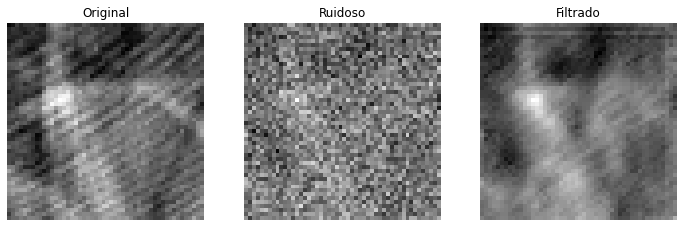

In [ ]:
mostrar_lado_a_lado(imagens=[y_test[100,:,:,0], x_test[100,:,:,0], predicted[100,:,:,0]], titulos=['Original', 'Ruidoso', 'Filtrado'])

In [ ]:
y_test[100].shape

(50, 50, 1)

In [ ]:
pnsr_img = PSNR(y_test[100].reshape(1,50,50,1), predicted[100].reshape(1,50,50,1))
ssim_img = SSIM(y_test[100].reshape(1,50,50,1), predicted[100].reshape(1,50,50,1))

print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(pnsr_img).mean(), np.array(ssim_img).mean()))

PSNR médio: 21.13 dB e SSIM médio 0.56.


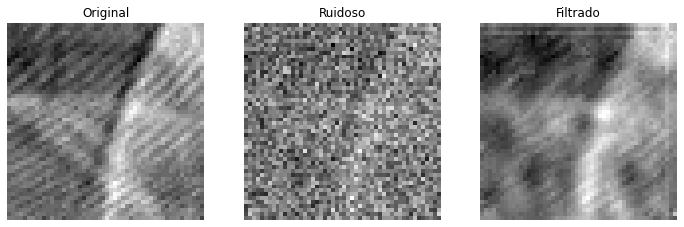

In [ ]:
mostrar_lado_a_lado(imagens=[y_test[500,:,:,0], x_test[500,:,:,0], predicted[500,:,:,0]], titulos=['Original', 'Ruidoso', 'Filtrado'])

In [ ]:
pnsr_img = PSNR(y_test[500].reshape(1,50,50,1), predicted[500].reshape(1,50,50,1))
ssim_img = SSIM(y_test[500].reshape(1,50,50,1), predicted[500].reshape(1,50,50,1))

print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(pnsr_img).mean(), np.array(ssim_img).mean()))

PSNR médio: 20.40 dB e SSIM médio 0.53.


## Compairing PSNR and SSIM of projections filtered by the network

In [ ]:
from denoising.measures import PSNR, SSIM

In [ ]:
psnr = PSNR(y_test, x_test)
ssim = SSIM(y_test, x_test)

In [ ]:
print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(psnr).mean(), np.array(ssim).mean()))

PSNR médio: 18.99 dB e SSIM médio 0.30.


In [104]:
psnr_pred = PSNR(y_test, predicted)
ssim_pred = SSIM(y_test, predicted)

In [105]:
print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(psnr_pred).mean(), np.array(ssim_pred).mean()))

PSNR médio: 26.92 dB e SSIM médio 0.71.


# Average PSNR increased by 7.93 dB and avg. SSIM increased by 0.41.